In [1]:
import multiprocessing as mp
import os
import pickle
import random
import re
import sys

import numpy as np
import pandas as pd
import tmap
import tmap as tm
from faerun import Faerun
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Descriptors
from tqdm import tqdm
from tqdm.auto import trange

RDLogger.DisableLog('rdApp.*')

import collections
import os
import pickle
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

from util import *

In [4]:
df = pd.read_csv("../../data/processed/surechembl/250106_sorted.tsv", sep="\t")

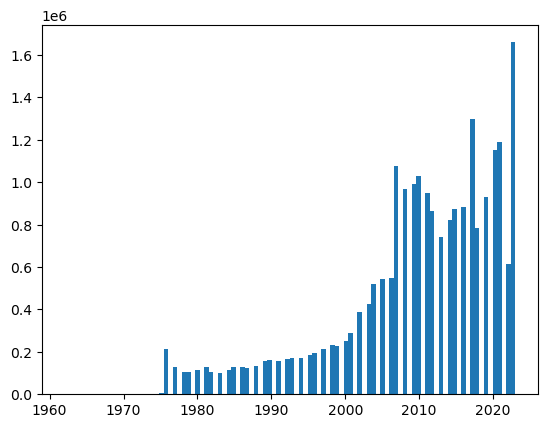

In [ ]:
dates_all = [int(df["DATE"][i].split("-")[0]) for i in range(len(df))]
plt.hist(dates_all, bins=100)
plt.show()

In [25]:
print(max(dates_all), min(dates_all), max(dates_all) - min(dates_all))

2023 1962 61


In [29]:
blue = 0
red = 0

for i in trange(len(dates_all)):
    if dates_all[i] <= 1990:
        blue += 1
    elif dates_all[i] >= 2023:
        red += 1

print(blue, red)

100%|██████████| 23465171/23465171 [00:20<00:00, 1149504.30it/s]

1952697 1660465


In [30]:
indices = [i for i in range(len(df))]
sample_size = 1000000

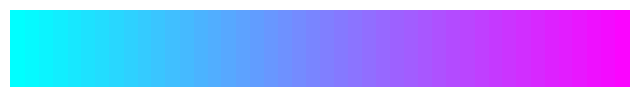

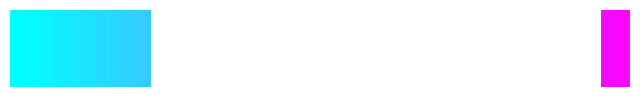

In [ ]:
num_colors = 1980
total_colors = 2023 - 1980 + 1

base_cmap = plt.get_cmap("cool")
colors = [base_cmap(i / total_colors) for i in range(total_colors)]

black_section = [(0, 0, 0, 0)] * num_colors
new_colors = black_section + colors

colors_section = new_colors[num_colors:]

MY_CM = LinearSegmentedColormap.from_list("my_map_black", colors_section, N=len(colors_section))
MY_CM_FULL = LinearSegmentedColormap.from_list("my_map_black", new_colors, N=len(new_colors))

gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(8, 1))
plt.imshow(gradient, aspect="auto", cmap=MY_CM)
plt.axis("off")
plt.show()

for i in range(10, len(colors_section) - 2):
    colors_section[i] = (0, 0, 0, 0)

new_colors[num_colors:] = colors_section

MY_CM = LinearSegmentedColormap.from_list("my_map_black", colors_section, N=len(colors_section))
MY_CM_3 = LinearSegmentedColormap.from_list("my_map_black", new_colors, N=len(new_colors))

gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(8, 1))
plt.imshow(gradient, aspect="auto", cmap=MY_CM)
plt.axis("off")
plt.show()

In [ ]:
scores = []
num_permutations = 1000  # 試行回数

In [ ]:
for id in range(1, 10):
    if id == 0:
        start_time = time.time()

    random.seed(id)

    output_dir = f"../../data/result/tmap/{id}"
    smiles_path = os.path.join(output_dir, "smiles.pkl")
    years_path = os.path.join(output_dir, "years.pkl")
    ecfps_path = os.path.join(output_dir, "ecfps.pkl")

    if os.path.exists(smiles_path) and os.path.exists(years_path) and os.path.exists(ecfps_path):
        print(f"ID {id} のデータが既に存在するためスキップします。")
        smiles = pickle_load(smiles_path)
        years = pickle_load(years_path)
        ecfps = pickle_load(ecfps_path)
    else:
        os.makedirs(output_dir, exist_ok=True)
        random.seed(id)

        sample_indices = random.sample(indices, sample_size)
        smiles, years, ecfps = [], [], []

        for i in sample_indices:
            s = df.iloc[i, 0]
            y = int(df.iloc[i, 1].split("-")[0])
            ecfp = compute_ecfp(s)
            if ecfp is not None:
                smiles.append(s)
                years.append(y)
                ecfps.append(ecfp)

        print(f"保存: smiles({len(smiles)}), years({len(years)}), ecfps({len(ecfps)})")
        pickle_dump(smiles, smiles_path)
        pickle_dump(years, years_path)
        pickle_dump(ecfps, ecfps_path)

    if id == 0:
        elapsed_time = time.time() - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"loaded data for i=0: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")

    filepaths = {
        "x": f"{output_dir}/x.pkl",
        "y": f"{output_dir}/y.pkl",
        "s": f"{output_dir}/s.pkl",
        "t": f"{output_dir}/t.pkl",
    }

    if all(os.path.exists(path) for path in filepaths.values()):
        print(f"ID {id}: すでに処理済みのためスキップ")
    else:
        enc = tm.Minhash(256)
        lf = tm.LSHForest(256)

        d, n = 2048, len(ecfps)
        data = [tm.VectorUchar(np.array(ecfps[x])) for x in trange(n)]
        
        lf.batch_add(enc.batch_from_binary_array(data))
        lf.index()

        knng_from, knng_to, knng_weight = tm.VectorUint(), tm.VectorUint(), tm.VectorFloat()
        _ = lf.get_knn_graph(knng_from, knng_to, knng_weight, 10)
        x, y, s, t, _ = tm.layout_from_lsh_forest(lf)

        pickle_dump(list(x), filepaths["x"])
        pickle_dump(list(y), filepaths["y"])
        pickle_dump(list(s), filepaths["s"])
        pickle_dump(list(t), filepaths["t"])

    if id == 0:
        elapsed_time = time.time() - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"made knn graph for i=0: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")

    labels_full = [1980 if year <= 1980 else 2023 if year >= 2023 else year for year in years]
    labels_3 = [0 if year <= 1990 else 2 if year >= 2023 else 1 for year in years]
    labels_3, labels_full = np.array(labels_3), np.array(labels_full)

    output_plot = os.path.join(output_dir, f"surechembl_{id}.html")
    if not os.path.exists(output_plot):
        faerun = Faerun(clear_color="#111111", view="front", coords=False)
        faerun.add_scatter(
            f"surechembl_{id}",
            {"x": x, "y": y, "c": [labels_full, labels_full], "labels": smiles},
            colormap=[MY_CM_FULL, MY_CM_3],
            shader="smoothCircle",
            series_title=["Year", "Year"],
            point_scale=2.5,
            max_point_size=10,
            has_legend=True,
            categorical=True,
        )
        faerun.add_tree(
            f"surechembl_{id}_tree", {"from": s, "to": t}, point_helper=f"surechembl_{id}", color="#666666"
        )
        faerun.plot(f"surechembl_{id}", template="smiles")
    else:
        print(f"Skipping {output_plot}, already exists.")

    scores.append([id, lsh_forest_purity(s, t, labels_3), "3"])
    scores.append([id, lsh_forest_purity(s, t, labels_full), "full"])

    for labels, label_type in [(labels_3, "3"), (labels_full, "full")]:
        lsh_purity_real = lsh_forest_purity(s, t, labels)
        random_purities = []
        for _ in range(num_permutations):
            shuffled_labels = np.random.permutation(labels)
            random_purity = lsh_forest_purity(s, t, shuffled_labels)
            random_purities.append(random_purity)

        random_purities = np.array(random_purities)
        p_value = np.mean(random_purities >= lsh_purity_real)

        scores.append([id, p_value, label_type])
    hist_3_path = os.path.join(output_dir, "hist_3.png")
    hist_full_path = os.path.join(output_dir, "hist_full.png")

    if not os.path.exists(hist_3_path):
        plt.figure()
        plt.hist(labels_3, bins=3, color="blue", alpha=0.5)
        plt.title("Histogram of labels_3")
        plt.xlabel("Labels")
        plt.ylabel("Frequency")
        plt.savefig(hist_3_path)
        plt.close()
    else:
        print(f"Skipping {hist_3_path}, already exists.")

    if not os.path.exists(hist_full_path):
        plt.figure()
        plt.hist(labels_full, bins=43, color="red", alpha=0.5)
        plt.title("Histogram of labels_full")
        plt.xlabel("Labels")
        plt.ylabel("Frequency")
        plt.savefig(hist_full_path)
        plt.close()
    else:
        print(f"Skipping {hist_full_path}, already exists.")

    c = collections.Counter(labels_3)

    if id == 0:
        elapsed_time = time.time() - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"Execution time for i=0: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")

    print(f"Done {id}: {c}")

ID 1 のデータが既に存在するためスキップします。


100%|██████████| 996698/996698 [43:40<00:00, 380.42it/s]


/workspace/HDD1/user/ohto_2/1-project/2-tox_pred/2-patent_date_split/github/patent_time_split/notebook/experiment/surechembl_1.html

Done 1: Counter({np.int64(1): 843468, np.int64(0): 82731, np.int64(2): 70499})
保存: smiles(996666), years(996666), ecfps(996666)


100%|██████████| 996666/996666 [43:19<00:00, 383.36it/s]


/workspace/HDD1/user/ohto_2/1-project/2-tox_pred/2-patent_date_split/github/patent_time_split/notebook/experiment/surechembl_2.html

Done 2: Counter({np.int64(1): 843526, np.int64(0): 82637, np.int64(2): 70503})
保存: smiles(996895), years(996895), ecfps(996895)


100%|██████████| 996895/996895 [43:08<00:00, 385.07it/s]


/workspace/HDD1/user/ohto_2/1-project/2-tox_pred/2-patent_date_split/github/patent_time_split/notebook/experiment/surechembl_3.html

Done 3: Counter({np.int64(1): 843994, np.int64(0): 82753, np.int64(2): 70148})
保存: smiles(996762), years(996762), ecfps(996762)


100%|██████████| 996762/996762 [42:48<00:00, 388.09it/s]


/workspace/HDD1/user/ohto_2/1-project/2-tox_pred/2-patent_date_split/github/patent_time_split/notebook/experiment/surechembl_4.html

Done 4: Counter({np.int64(1): 843276, np.int64(0): 83124, np.int64(2): 70362})
保存: smiles(996736), years(996736), ecfps(996736)


100%|██████████| 996736/996736 [42:25<00:00, 391.60it/s]


/workspace/HDD1/user/ohto_2/1-project/2-tox_pred/2-patent_date_split/github/patent_time_split/notebook/experiment/surechembl_5.html

Done 5: Counter({np.int64(1): 843273, np.int64(0): 82969, np.int64(2): 70494})
保存: smiles(996821), years(996821), ecfps(996821)


100%|██████████| 996821/996821 [42:00<00:00, 395.48it/s]


/workspace/HDD1/user/ohto_2/1-project/2-tox_pred/2-patent_date_split/github/patent_time_split/notebook/experiment/surechembl_6.html

Done 6: Counter({np.int64(1): 843449, np.int64(0): 82974, np.int64(2): 70398})
保存: smiles(996879), years(996879), ecfps(996879)


100%|██████████| 996879/996879 [43:02<00:00, 386.01it/s]


/workspace/HDD1/user/ohto_2/1-project/2-tox_pred/2-patent_date_split/github/patent_time_split/notebook/experiment/surechembl_7.html

Done 7: Counter({np.int64(1): 843603, np.int64(0): 82610, np.int64(2): 70666})
保存: smiles(996830), years(996830), ecfps(996830)


100%|██████████| 996830/996830 [43:53<00:00, 378.50it/s]


/workspace/HDD1/user/ohto_2/1-project/2-tox_pred/2-patent_date_split/github/patent_time_split/notebook/experiment/surechembl_8.html

Done 8: Counter({np.int64(1): 843348, np.int64(0): 83203, np.int64(2): 70279})
保存: smiles(996735), years(996735), ecfps(996735)


100%|██████████| 996735/996735 [43:21<00:00, 383.16it/s]


/workspace/HDD1/user/ohto_2/1-project/2-tox_pred/2-patent_date_split/github/patent_time_split/notebook/experiment/surechembl_9.html

Done 9: Counter({np.int64(1): 843480, np.int64(0): 82623, np.int64(2): 70632})


In [ ]:
def lsh_forest_purity(s, t, labels):
    matches = (labels[s] == labels[t]) 
    purity = np.sum(matches) / len(matches)
    return purity

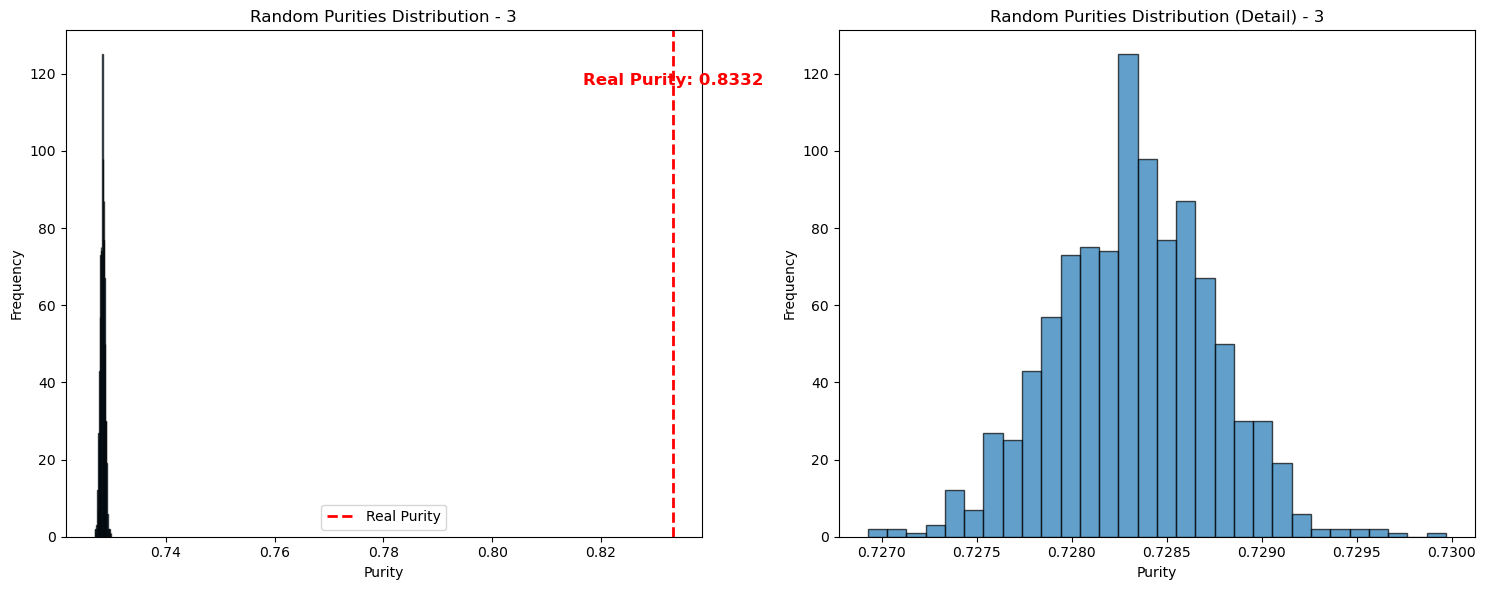

0 0.0 3


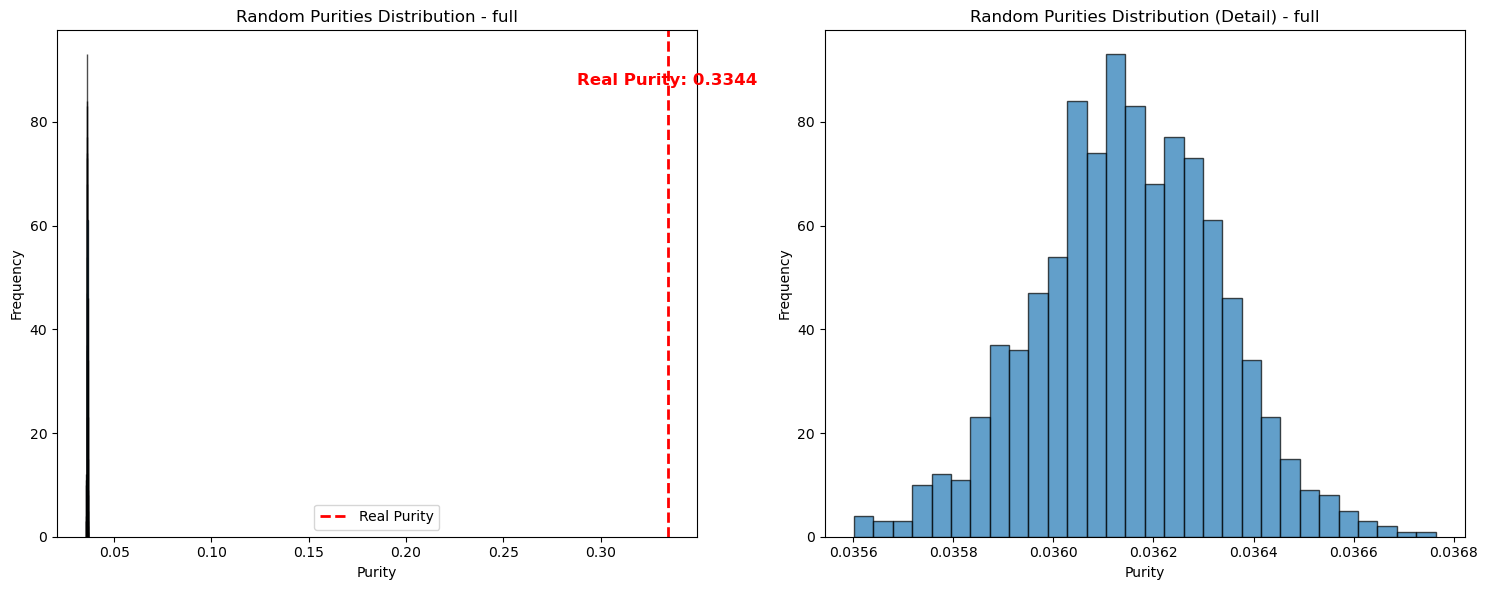

0 0.0 full
Done 0: Counter({np.int64(1): 843657, np.int64(0): 82811, np.int64(2): 70252})


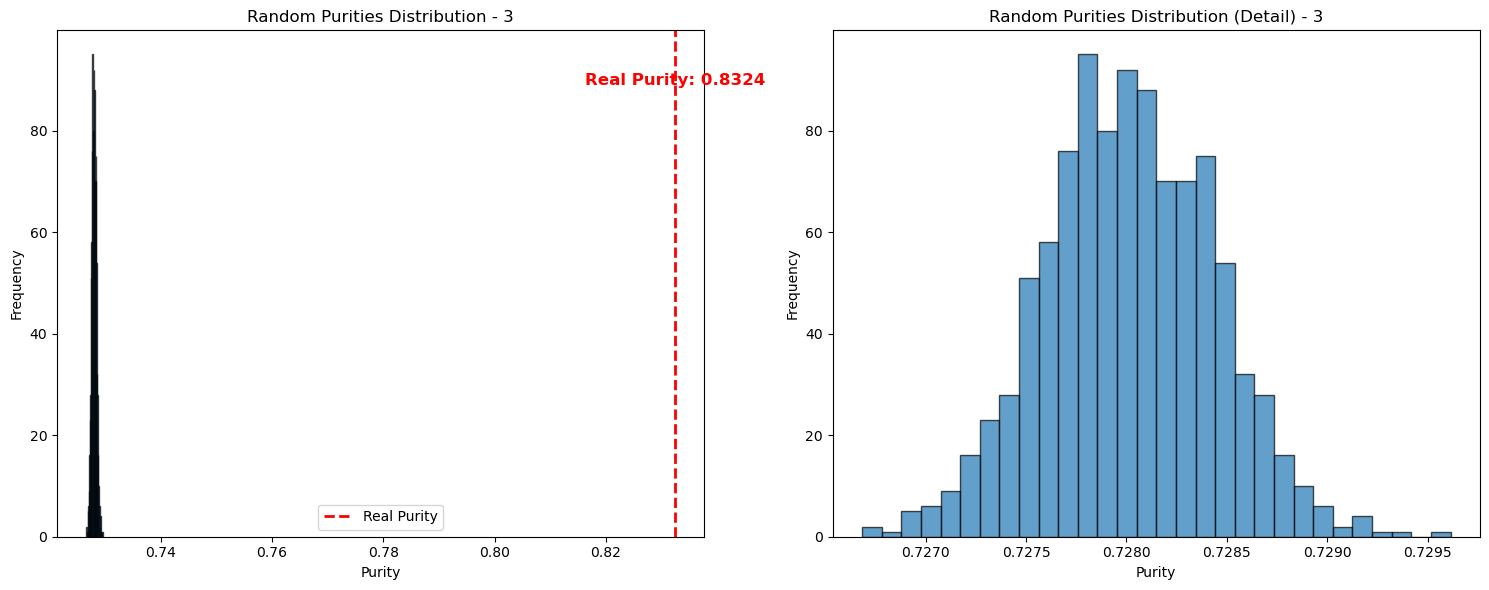

1 0.0 3


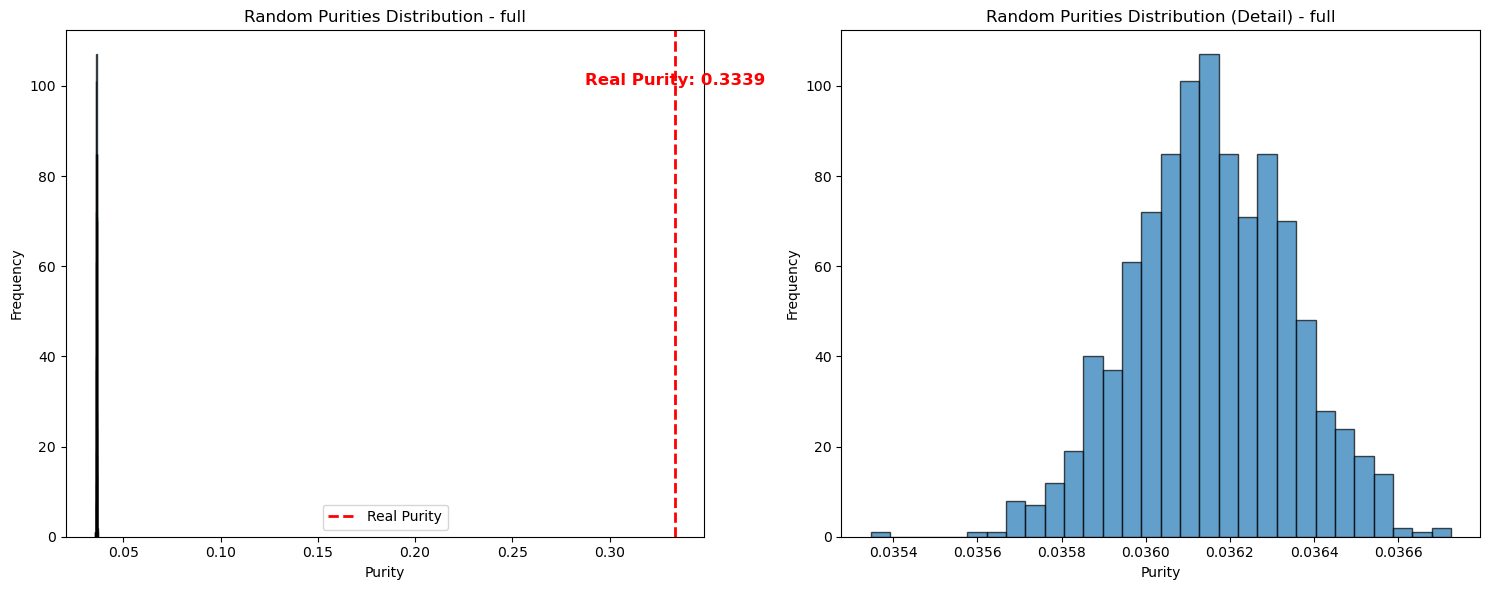

1 0.0 full
Done 1: Counter({np.int64(1): 843468, np.int64(0): 82731, np.int64(2): 70499})


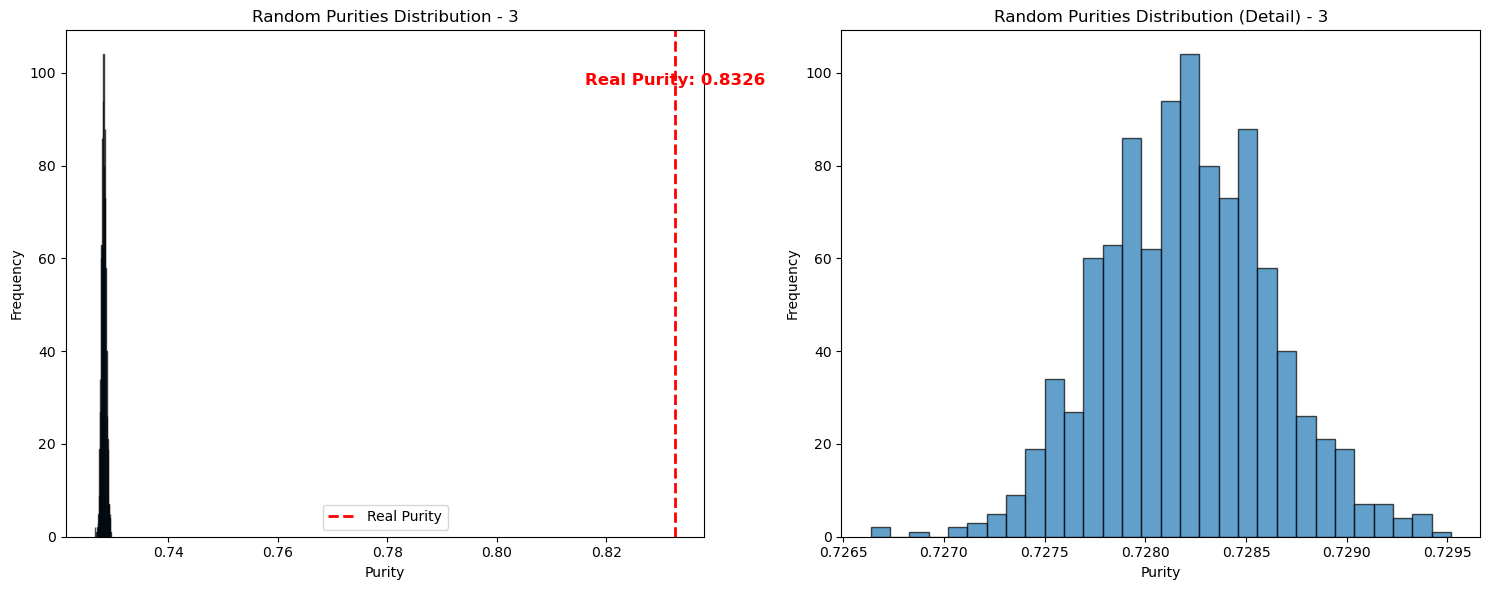

2 0.0 3


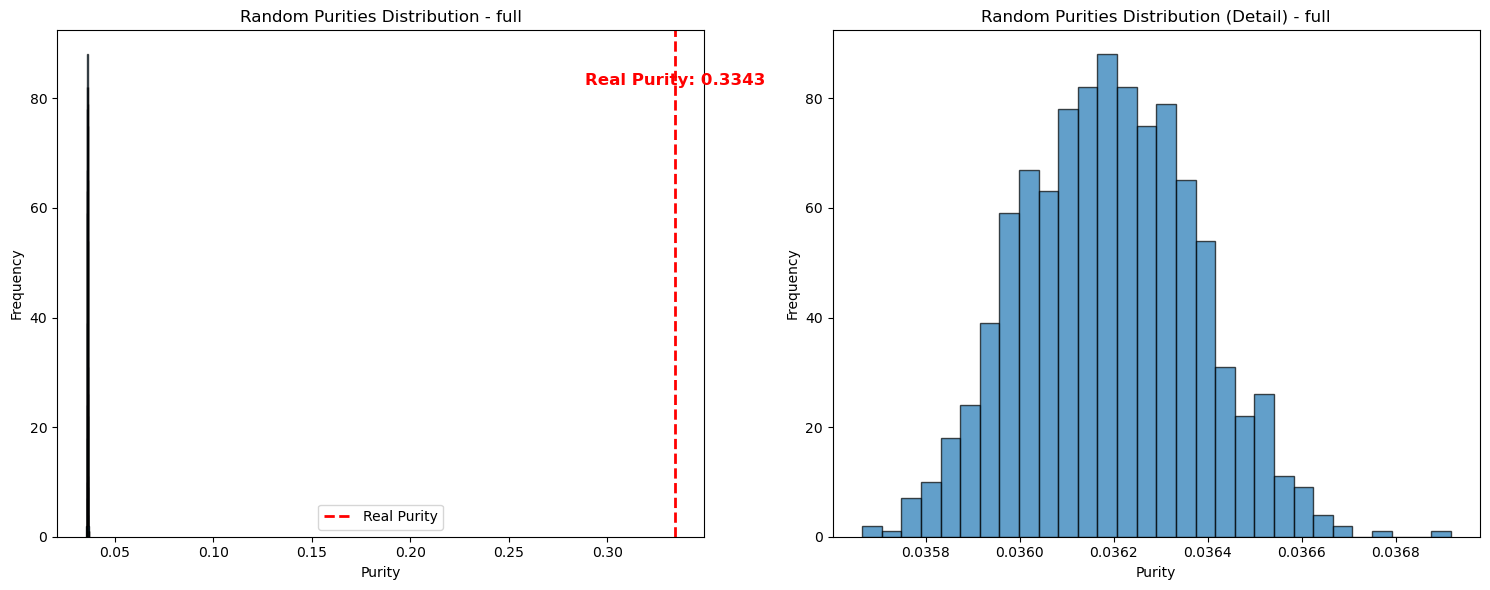

2 0.0 full
Done 2: Counter({np.int64(1): 843526, np.int64(0): 82637, np.int64(2): 70503})


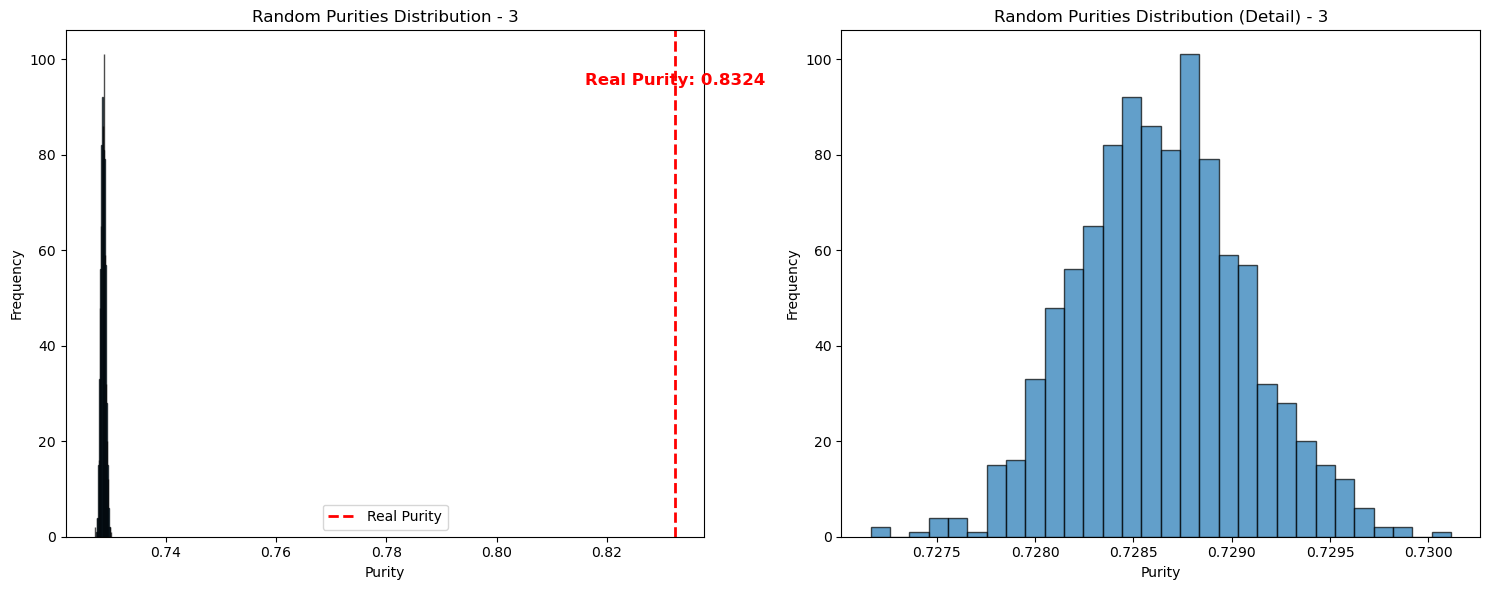

3 0.0 3


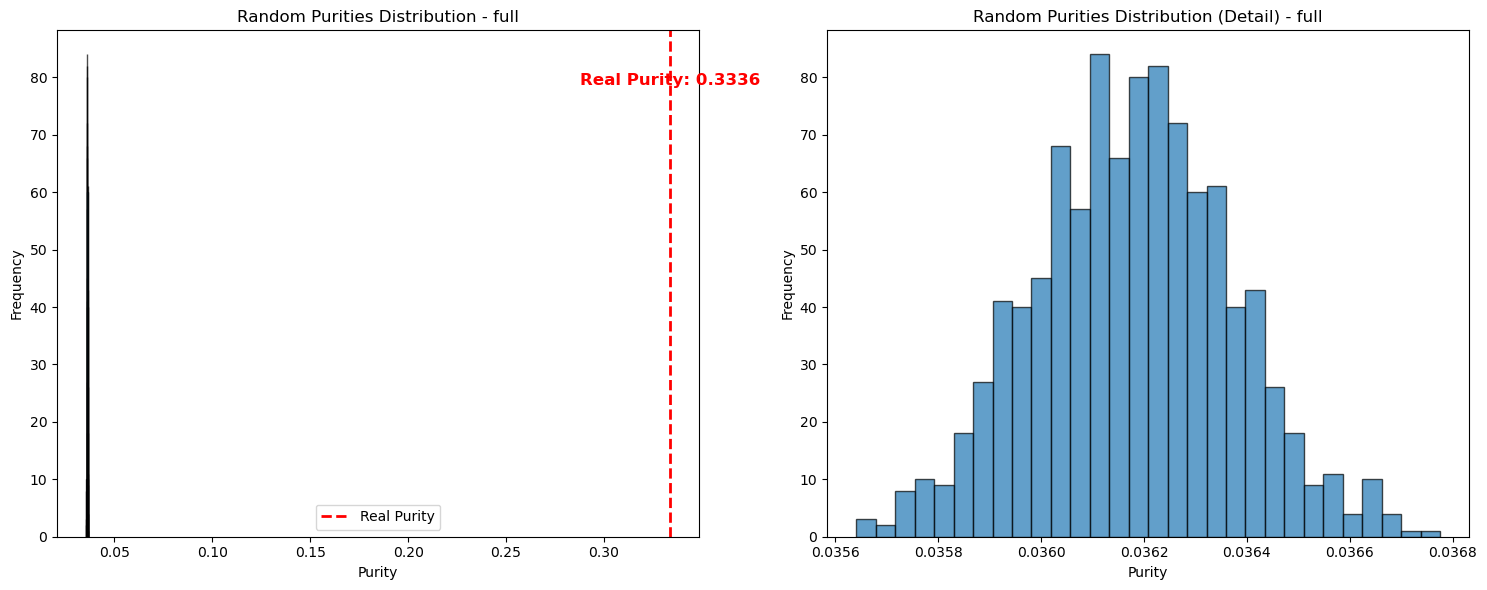

3 0.0 full
Done 3: Counter({np.int64(1): 843994, np.int64(0): 82753, np.int64(2): 70148})


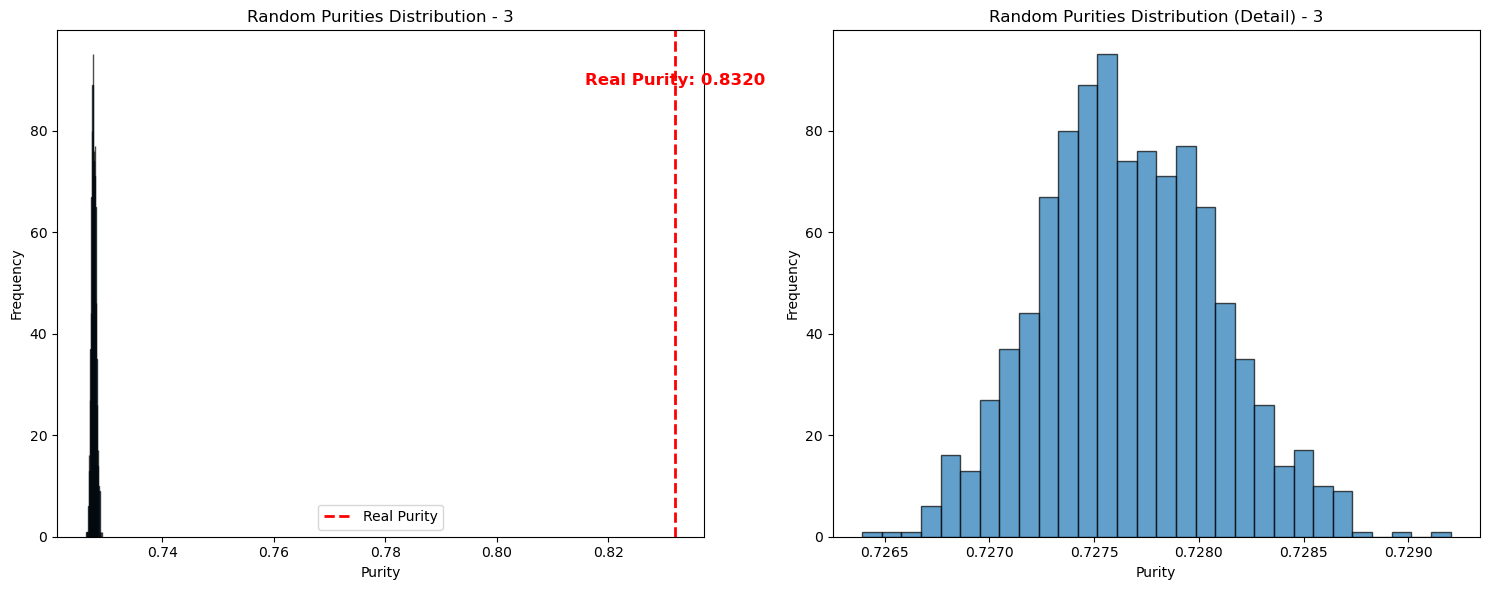

4 0.0 3


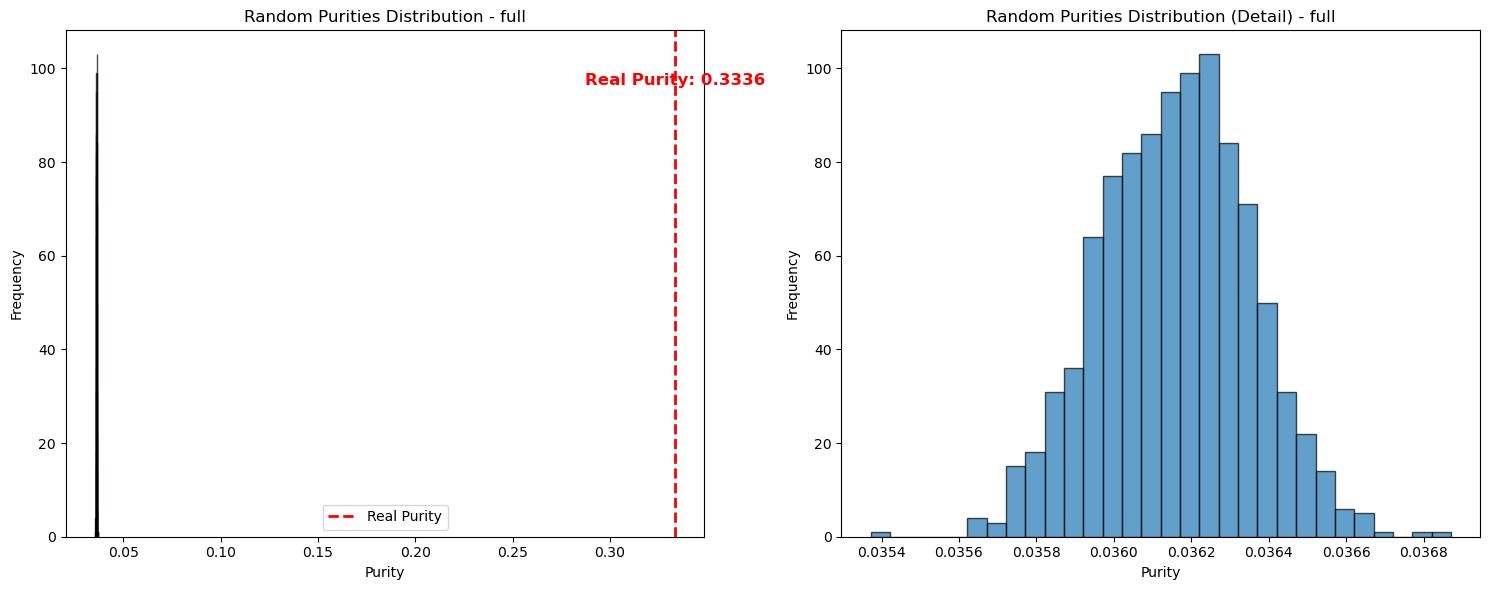

4 0.0 full
Done 4: Counter({np.int64(1): 843276, np.int64(0): 83124, np.int64(2): 70362})


 24%|██▍       | 243067/996698 [25:04:44<77:45:26,  2.69it/s]
/tmp/ipykernel_798733/2528235841.py:75: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # レイアウト調整


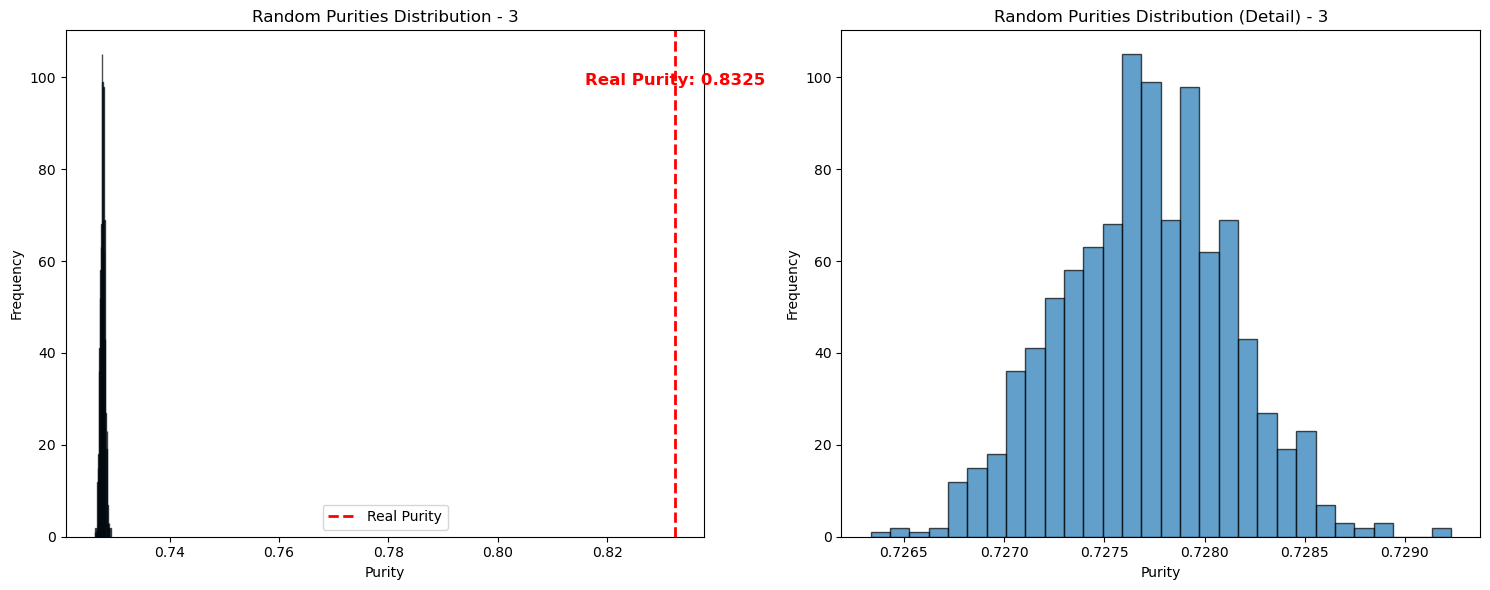

5 0.0 3


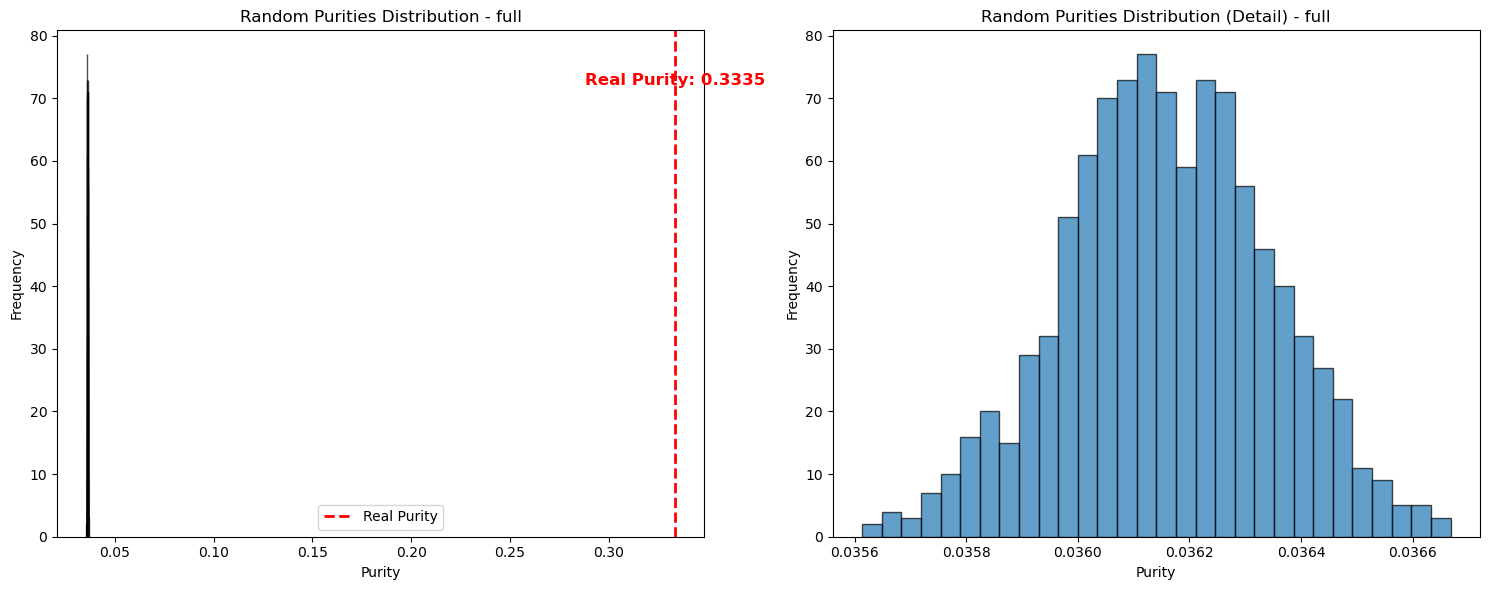

5 0.0 full
Done 5: Counter({np.int64(1): 843273, np.int64(0): 82969, np.int64(2): 70494})


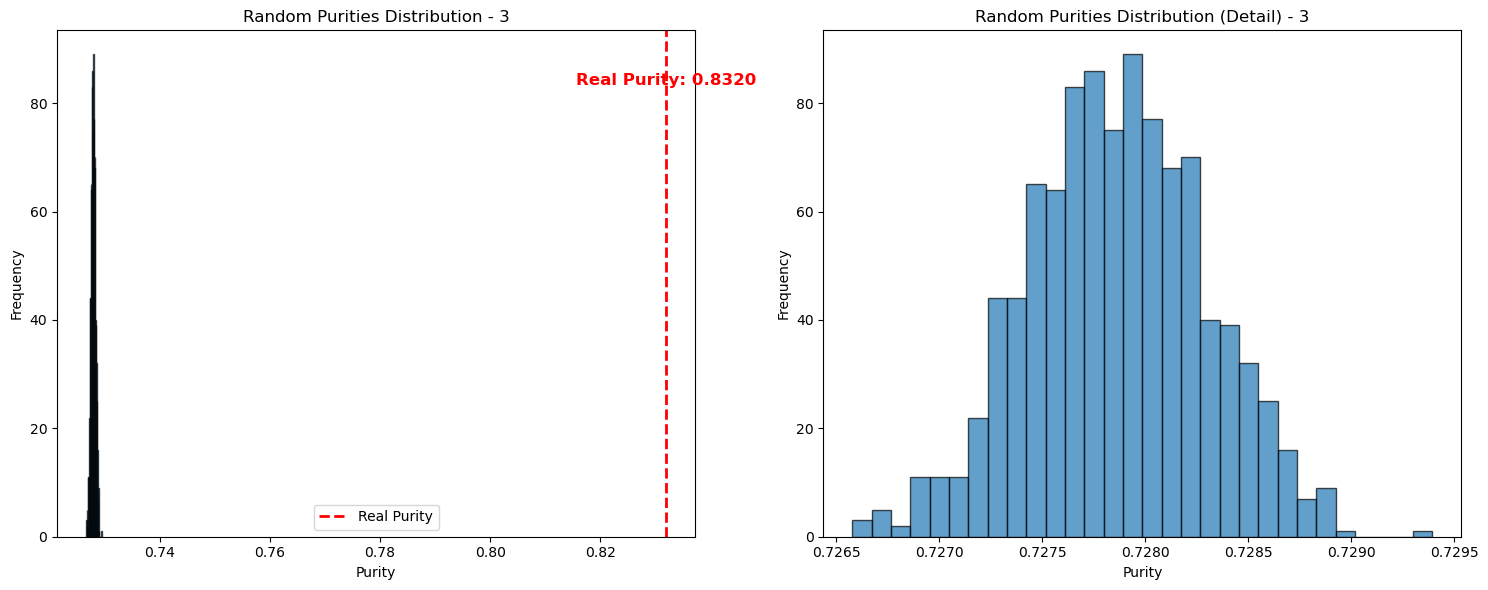

6 0.0 3


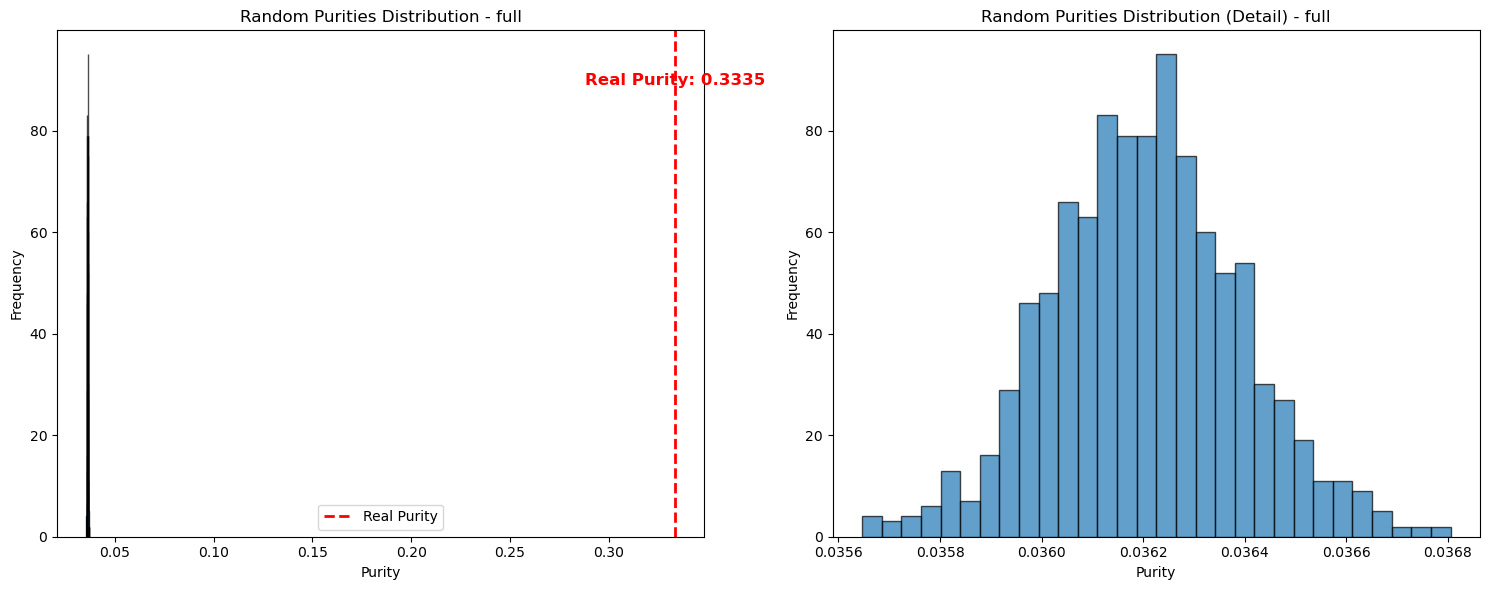

6 0.0 full
Done 6: Counter({np.int64(1): 843449, np.int64(0): 82974, np.int64(2): 70398})


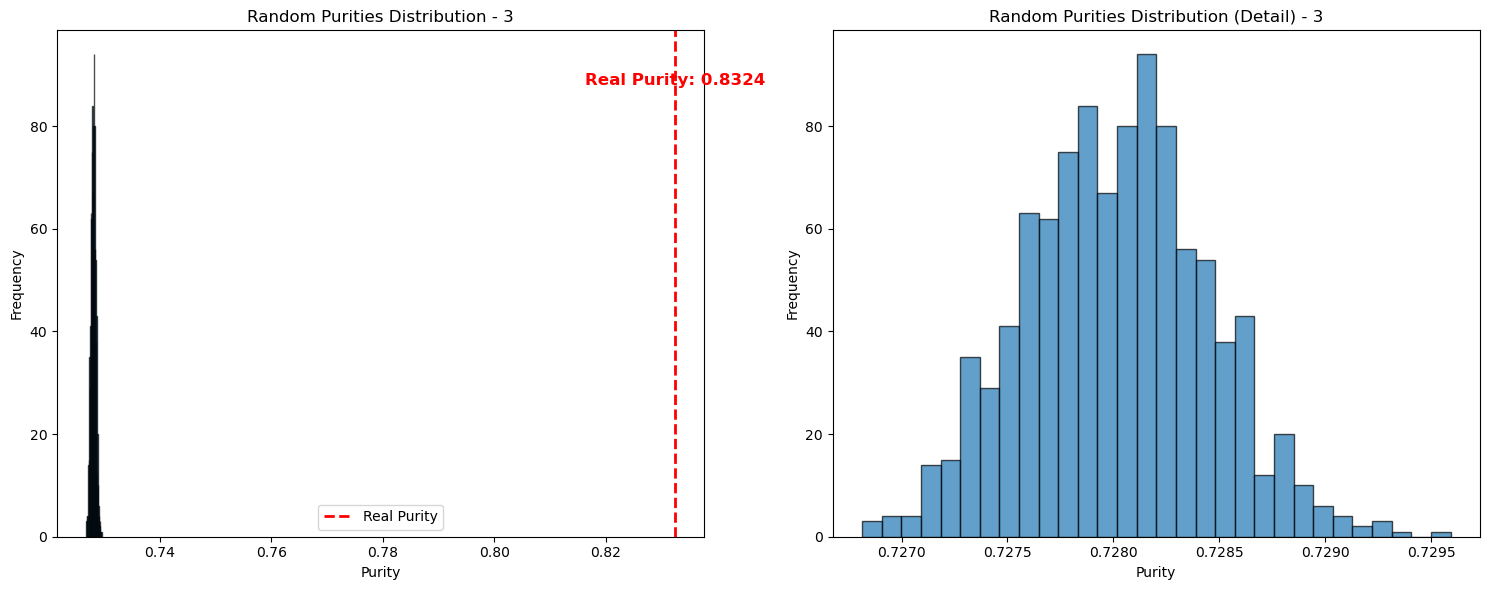

7 0.0 3


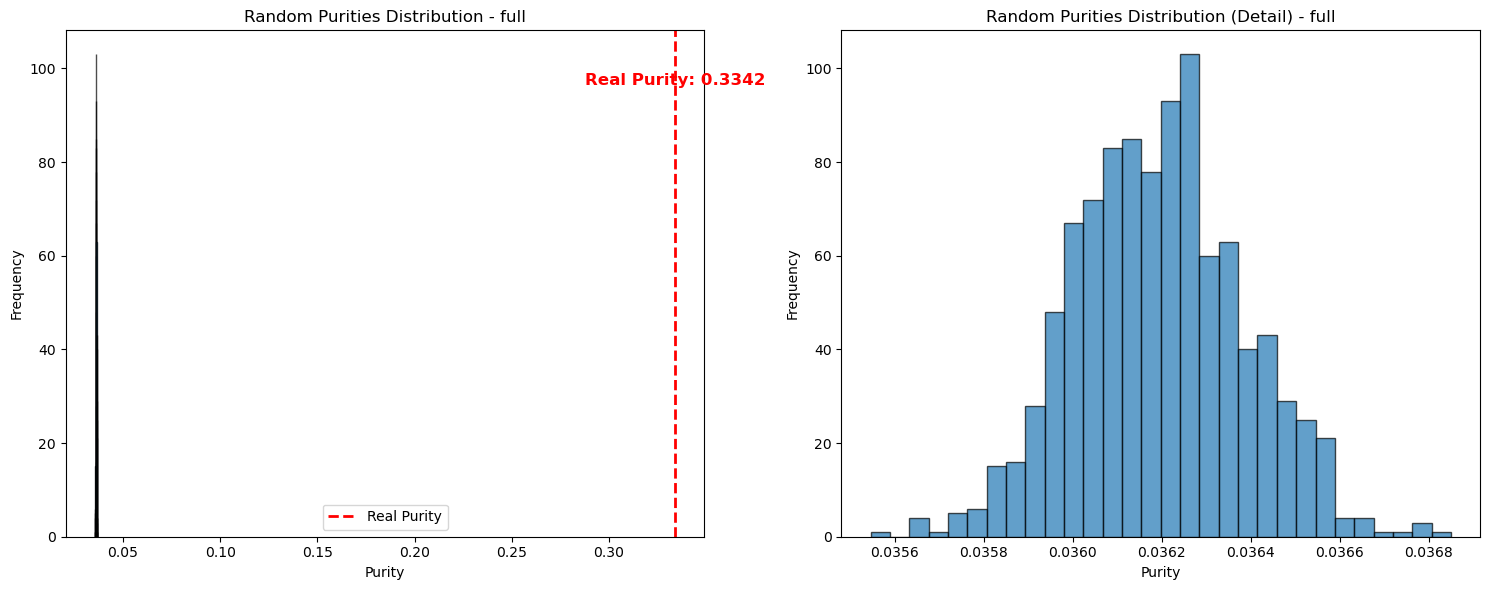

7 0.0 full
Done 7: Counter({np.int64(1): 843603, np.int64(0): 82610, np.int64(2): 70666})


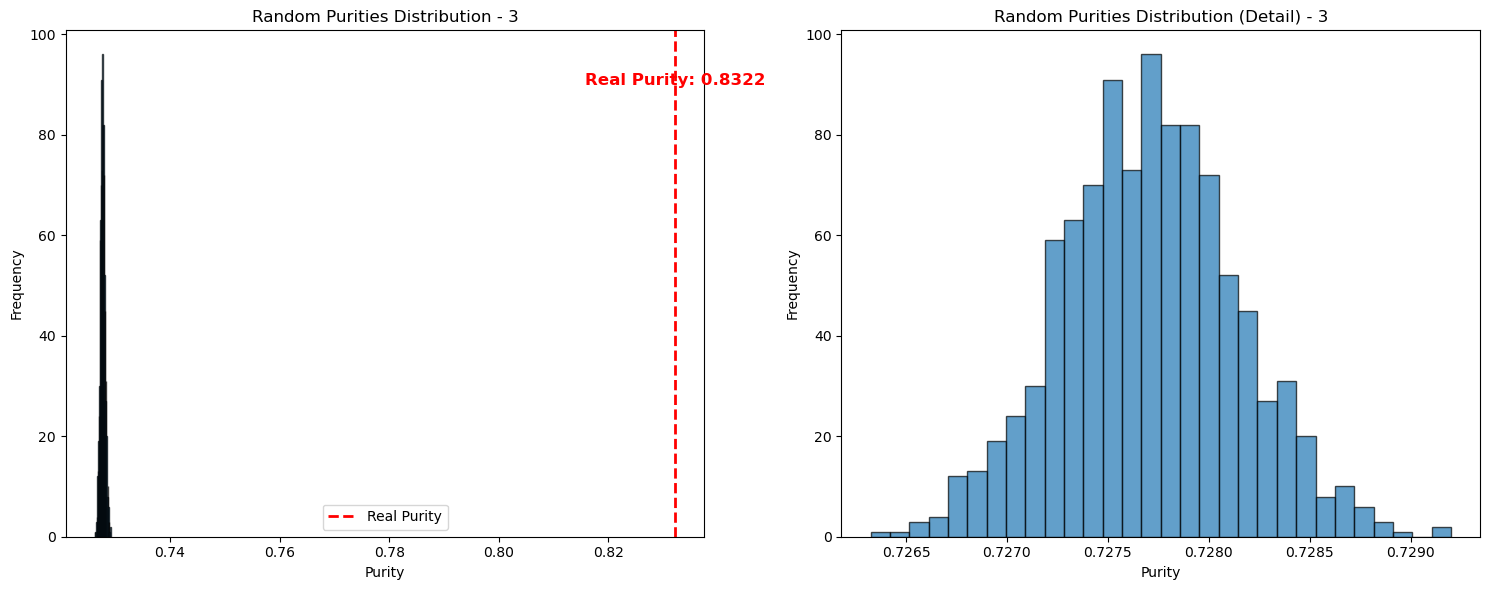

8 0.0 3


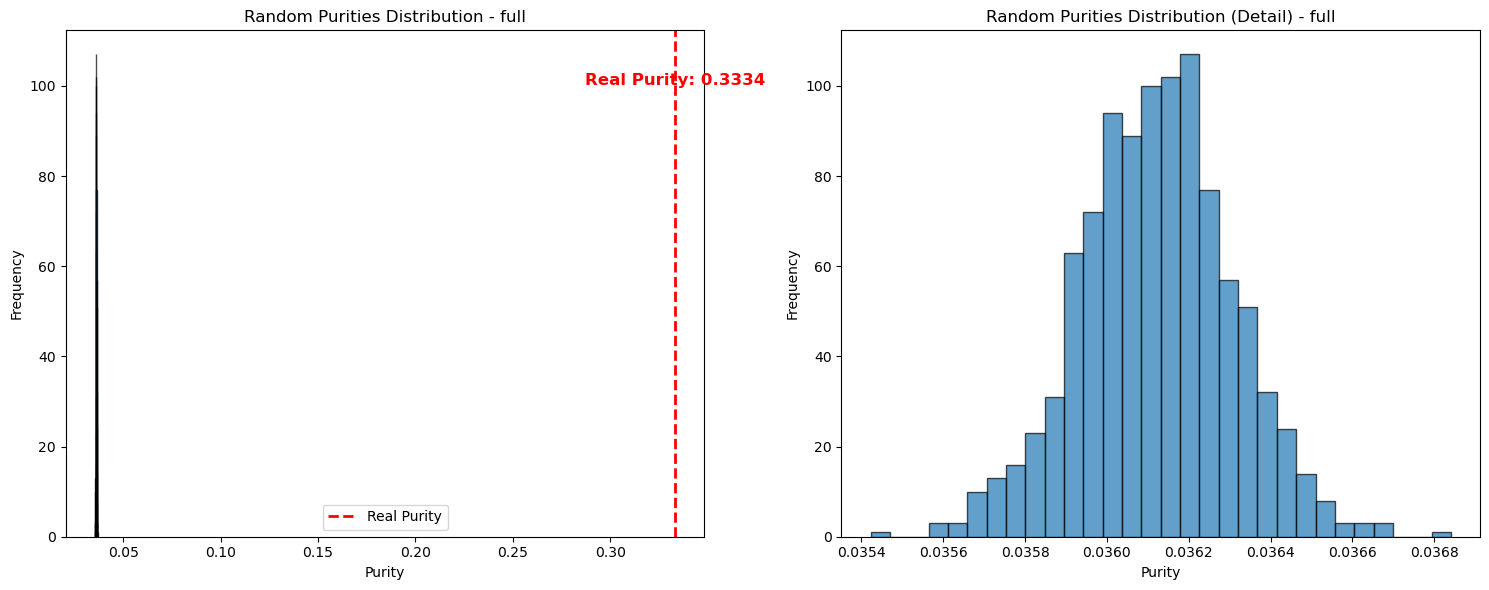

8 0.0 full
Done 8: Counter({np.int64(1): 843348, np.int64(0): 83203, np.int64(2): 70279})


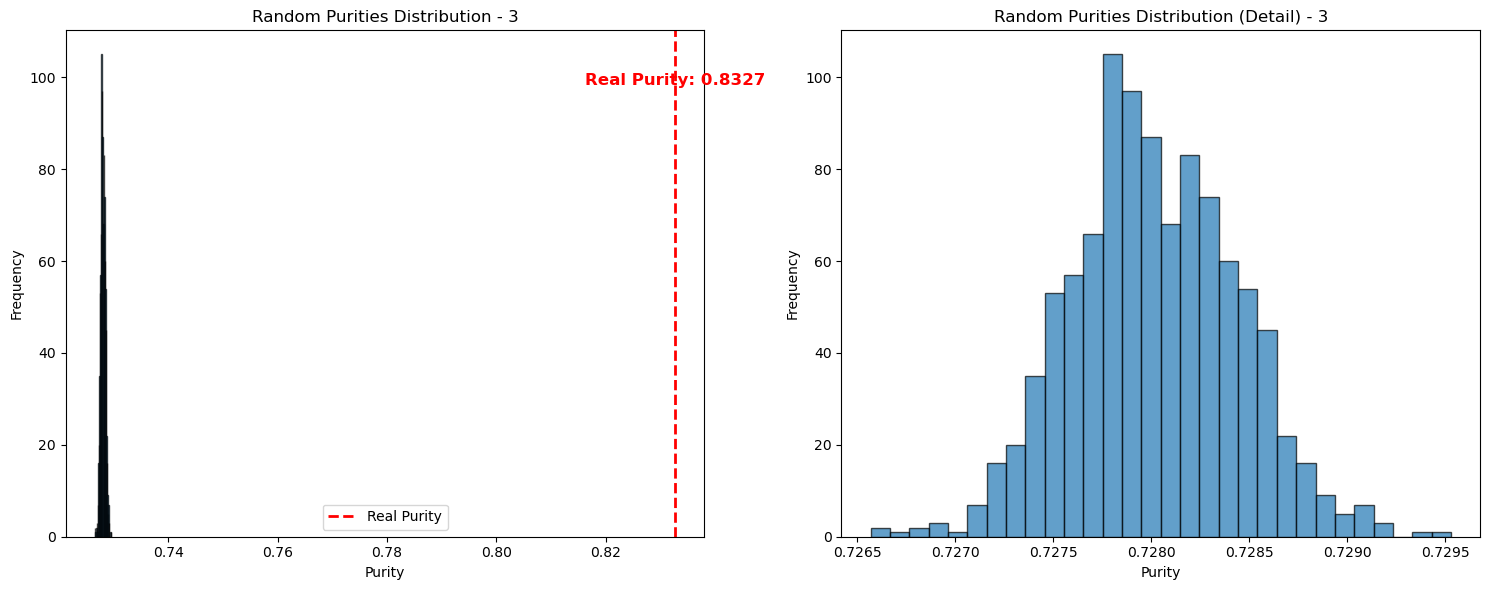

9 0.0 3


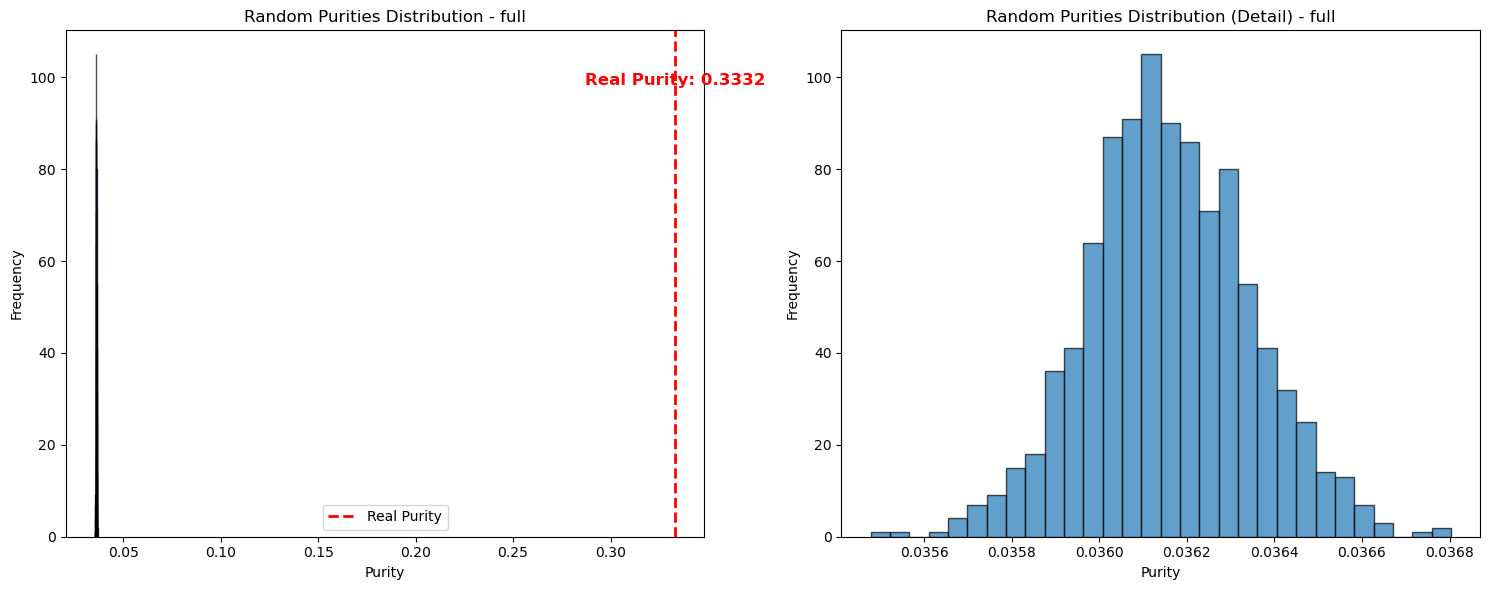

100%|██████████| 10/10 [1:36:51<00:00, 581.17s/it]

9 0.0 full
Done 9: Counter({np.int64(1): 843480, np.int64(0): 82623, np.int64(2): 70632})
統合p値 (labels_3): 0.00000e+00
統合p値 (labels_full): 0.00000e+00



/tmp/ipykernel_798733/2528235841.py:12: RuntimeWarning: divide by zero encountered in log
  chi2_stat = -2 * np.sum(np.log(p_values))


In [ ]:
def pickle_load(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def compute_combined_pvalue(p_values):
    chi2_stat = -2 * np.sum(np.log(p_values))
    dof = 2 * len(p_values) 
    combined_p = chi2.sf(chi2_stat, dof)
    return combined_p

num_permutations = 1000
scores = []
p_values_3 = []
p_values_full = []

for id in trange(10):
    output_dir = f"../../data/result/tmap/{id}"

    s_path = os.path.join(output_dir, "s.pkl")
    t_path = os.path.join(output_dir, "t.pkl")
    years_path = os.path.join(output_dir, "years.pkl")

    if not (os.path.exists(s_path) and os.path.exists(t_path) and os.path.exists(years_path)):
        print(f"Skipping ID {id}, required files missing.")
        continue

    s = pickle_load(s_path)
    t = pickle_load(t_path)
    years = pickle_load(years_path)
    labels_full = [1980 if year <= 1980 else 2023 if year >= 2023 else year for year in years]
    labels_3 = [0 if year <= 1990 else 2 if year >= 2023 else 1 for year in years]
    labels_3, labels_full = np.array(labels_3), np.array(labels_full)

    for labels, label_type in [(labels_3, "3"), (labels_full, "full")]:
        lsh_purity_real = lsh_forest_purity(s, t, labels)
        random_purities = []

        for _ in range(num_permutations):
            shuffled_labels = np.random.permutation(labels)
            random_purity = lsh_forest_purity(s, t, shuffled_labels)
            random_purities.append(random_purity)

        random_purities = np.array(random_purities)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 
        
        axs[0].hist(random_purities, bins=30, edgecolor='black', alpha=0.7)
        axs[0].axvline(lsh_purity_real, color='red', linestyle='dashed', linewidth=2, label='Real Purity')
        axs[0].set_title(f"Random Purities Distribution - {label_type}")
        axs[0].set_xlabel("Purity")
        axs[0].set_ylabel("Frequency")
        axs[0].legend()
        axs[0].text(lsh_purity_real, axs[0].get_ylim()[1] * 0.9, f'Real Purity: {lsh_purity_real:.4f}', 
                    color='red', ha='center', va='center', fontsize=12, fontweight='bold')

        axs[1].hist(random_purities, bins=30, edgecolor='black', alpha=0.7)
        axs[1].set_title(f"Random Purities Distribution (Detail) - {label_type}")
        axs[1].set_xlabel("Purity")
        axs[1].set_ylabel("Frequency")

        plt.tight_layout() 
        plt.savefig(f"../../data/result/tmap/{id}/random_purities_{label_type}.png")
        plt.show()

        p_value = np.mean(random_purities >= lsh_purity_real)
        print(id, p_value, label_type)

        scores.append([id, p_value, label_type])

        if label_type == "3":
            p_values_3.append(p_value)
        else:
            p_values_full.append(p_value)

    c = collections.Counter(labels_3)
    print(f"Done {id}: {c}")

if p_values_3:
    combined_p_3 = compute_combined_pvalue(p_values_3)
    print(f"統合p値 (labels_3): {combined_p_3:.5e}")

if p_values_full:
    combined_p_full = compute_combined_pvalue(p_values_full)
    print(f"統合p値 (labels_full): {combined_p_full:.5e}")


In [93]:
pd.DataFrame(scores, columns=["ID", "P-value", "Label Type"]).to_csv("../../data/result/tmap/scores.csv", index=False)

# all surechembl

In [ ]:
input_file = "../../data/processed/surechembl/250106_sorted.tsv"
output_ecfp = "../../data/processed/surechembl/surechembl_ecfp.pickle"
output_mol = "../../data/processed/surechembl/surechembl_mol.pickle"
output_year = "../../data/processed/surechembl/surechembl_year.pickle"

with open(input_file, "r") as f:
    lines = f.readlines()

total_lines = len(lines)

with open(input_file, "r") as f, open(output_ecfp, "ab") as pkl_out_ecfp, open(output_year, "ab") as pkl_out_year, open(pkl_out_smiles, "ab") as pkl_out_smiles:
    for line in tqdm(lines, total=total_lines, desc="Processing SMILES"):
        try:
            smiles = line.split("\t")[0]
            year = int(line.split("\t")[1].split("-")[0])
        except ValueError:
            print(f"Skipping line due to ValueError: {line.strip()}")
            continue
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
            pickle.dump(ecfp, pkl_out_ecfp, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(smiles, pkl_out_smiles, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(year, pkl_out_year, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
output_ecfp = "../../data/processed/surechembl/surechemble_ecfps.pickle"
output_smiles = "../../data/processed/surechembl/surechemble_smiles.pickle"
output_year = "../../data/processed/surechembl/surechemble_years.pickle"

smiles = pickle_load(output_smiles)
year = pickle_load(output_year)
ecfp = pickle_load(output_ecfp)

In [8]:
print(len(smiles), len(year), len(ecfp))

23389481 23389481 23389481


In [14]:
print(smiles[0])
print(year[0])
print(ecfp[0])

OC1=C2C=CC=CC2=CC2=CC3=C(CC=CC3)C=C12
1962


In [19]:
from tqdm import tqdm

def ecfp_to_set(fp):
    return set(fp.GetOnBits())

ecfp_sets = []
for e, y, s in zip(ecfp, year, smiles):
    ecfp_sets.append((ecfp_to_set(e), y, s))

Converting ECFP to set:   0%|          | 75631/23389481 [10:14<52:37:24, 123.06it/s]


In [21]:
print(len(ecfp_sets))

23389481


In [22]:
pickle_dump(ecfp_sets, "../../data/processed/surechembl/surechembl_ecfp_sets.pkl")

In [ ]:
ecfp_sets = pickle_load("../../data/processed/surechembl/surechembl_ecfp_sets.pkl")

In [23]:
from datasketch import MinHash, LeanMinHash

def create_lean_minhash(set_data, num_perm=64):
    m = MinHash(num_perm=num_perm)
    for item in set_data:
        m.update(str(item).encode('utf8'))
    return LeanMinHash(m) 

In [28]:
import pickle
from tqdm import tqdm

output_path = "../../data/processed/surechembl/minhash_list.pkl"

with open(output_path, "ab") as f:
    for data in tqdm(ecfp_sets):
        e, y, s = data[0], data[1], data[2]
        mh = create_lean_minhash(e)
        new_data = (mh, y, s)
        pickle.dump(new_data, f)

100%|██████████| 23389481/23389481 [8:40:25<00:00, 749.06it/s]   


In [29]:
import pickle
from datasketch import LeanMinHash
from tqdm import tqdm

def minhash_to_vector(minhash):
    return list(minhash.digest())

input_path = "../../data/processed/surechembl/minhash_list.pkl"  # 元のMinHashが1件ずつ保存されているpkl
output_path = "../../data/processed/surechembl/minhash_vectors.pkl"  # ベクトルを1件ずつ保存する先

k = 0
with open(input_path, "rb") as fin, open(output_path, "wb") as fout:
    while True:
        try:
            data = pickle.load(fin)  # 1件ずつ読み込む
            mh = data[0]  # MinHashを取得
            y = data[1]  # 年を取得
            s = data[2]  # SMILESを取得
            vec = minhash_to_vector(mh)  # ベクトルに変換
            new_data = (vec, y, s)  # 新しいデータを作成
            pickle.dump(new_data, fout)  # ベクトルを保存
        except EOFError:
            k += 1
            break

In [2]:
from tqdm.auto import trange
enc = tm.Minhash(64)
lf = tm.LSHForest(64)

d = 64
n = 23320261

data = []
input_path = "../../data/processed/surechembl/minhash_vectors.pkl" 

with open(input_path, "rb") as f:
    for _ in trange(n):
        try:
            vec = pickle.load(f)
            converted_vec = [np.uint8(x) for x in vec[0]]
            data.append(converted_vec)
        except EOFError:
            break

data = enc.batch_from_binary_array(data)
lf.batch_add(data)
lf.index()

  0%|          | 0/23320261 [00:00<?, ?it/s]

In [3]:
knng_from = tm.VectorUint()
knng_to = tm.VectorUint()
knng_weight = tm.VectorFloat()

_ = lf.get_knn_graph(knng_from, knng_to, knng_weight, 10)

In [ ]:
x, y, s, t, _ = tm.layout_from_lsh_forest(lf)

In [ ]:
output_dir = "../../data/result/tmap/surechembl/whole"

In [ ]:
os.makedirs(output_dir, exist_ok=True)

In [ ]:
filepaths = {
    "x": f"{output_dir}/x.pkl",
    "y": f"{output_dir}/y.pkl",
    "s": f"{output_dir}/s.pkl",
    "t": f"{output_dir}/t.pkl",
}

In [ ]:
pickle_dump(list(x), filepaths["x"])
pickle_dump(list(y), filepaths["y"])
pickle_dump(list(s), filepaths["s"])
pickle_dump(list(t), filepaths["t"])